# (26) Awake -- network

**Motivation**: Fit network objects and save (for CA awake data). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Mice

In [2]:
mice = Mice(Config(
    nn=512,
    sub_ids=[2, 6, 7, 9, 10],
    ses_ids=[4],
    run_ids=range(1, 10 + 1),
))
bs = Base(mice, mode='ca2')

## Fit net

In [3]:
props = {
    'mice': mice,
    'mode': 'ca2',
    'task': 'rest',
    'metric': 'pearson',
    'percentiles': np.linspace(30, 5, 6).astype(int),
    'prep_data': True,
    'binarize': False,
    'verbose': False,
}
bands = [None, 0.01, 0.5, (0.01, 0.5)]

In [3]:
pbar1 = tqdm(
    bands,
    leave=True,
    total=len(bands),
)
for b in pbar1:
    kwargs = {
        'task': props['task'],
        'desc': {'ca2': 'awake'},
        'runs_only': True,
        'exclude': True,
    }
    mice.setup_func_data(**kwargs)
    mice.set_band(band={'ca2': b})
    proc, *_ = mice.get_data_containers('ca2')
    pbar2 = tqdm(
        proc.items(),
        leave=False,
    )
    for key, func in pbar2:
        msg = f"running net (task-{props['task']}, "
        msg += f"b-{str(b).replace(' ', '')})"
        msg += f": {key}"
        pbar1.set_description(msg)
        net = Network(key=key, **props).fit_network(
            force=True, full=False, save=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

## Adjacencies

In [3]:
mice.set_band({'ca2': (0.01, 0.5)})
kwargs = {
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'desc': {'ca2': 'awake'},
}
adjacencies = collect_adjacencies(
    mice, 'ca2', **kwargs)[0]
adjacencies.shape

(31, 480, 480)

### Degree map

In [4]:
perc = 15
a_bin = []
for ii, adj in enumerate(adjacencies):
    thres = calculate_threshold(adj, perc / 100)
    thres = thres.pop()
    _a = adj.copy()
    _a[_a <= thres] = 0.0
    _a[_a > thres] = 1.0
    a_bin.append(_a)
a_bin = np.stack(a_bin)
a_bin.shape

(31, 480, 480)

In [5]:
deg = bn.nansum(a_bin, -1)
deg[deg == 0] = np.nan
deg.shape

(31, 480)

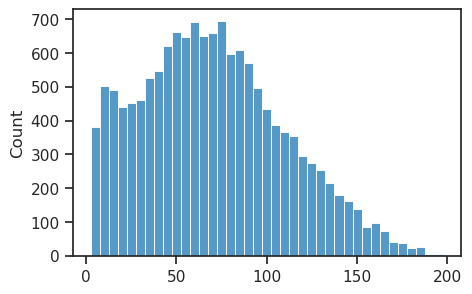

In [12]:
num_bins = 40
bin_edges = (5, 200)
bins = np.linspace(*bin_edges, num_bins)
bins -= 2.5

sns.histplot(deg.ravel(), bins=bins);

#### Binary

In [13]:
_ = bs.show(
    data=bn.nanmean(deg, 0),
    figsize=(4, 2.5),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

#### Weighted

In [14]:
a = bn.nanmean(adjacencies, 0)
a.shape

(480, 480)

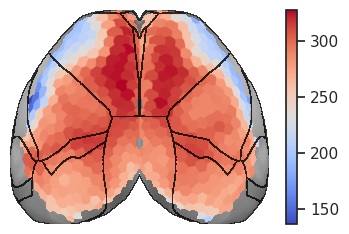

In [15]:
_ = bs.show(
    data=np.nansum(a, 0),
    figsize=(4, 2.5),
    vmin=None,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

## KMeans

In [16]:
a = bn.nanmean(adjacencies, 0)
a[np.isnan(a)] = 0
a.shape

(480, 480)

In [17]:
num_clusters = range(2, 9)
partition = np_nans((len(num_clusters), len(a)))
for i, k in enumerate(num_clusters):
    centroids, km = fit_kmeans(a, k, 'euclidean')
    partition[i] = km.predict(a) + 1

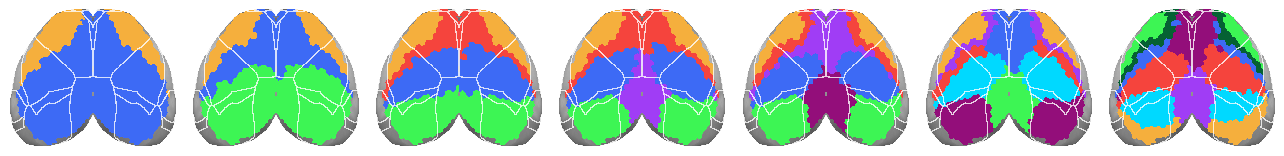

In [19]:
_ = bs.show(
    partition,
    vmin=1,
    vmax=k,
    interp='none',
    figsize=(13, 5),
    cmap=get_cluster_cmap(range(k)),
)

## SVINET + Group

TODO

In [20]:
total = count_sv_fitted(mice.cfg.svinet_dir, 'p15-sample')
remaining = {
    b: np.round(100 * sum(e == 0 for e in d.values()) / len(d), 1)
    for b, d in total.items()
}
remaining

{'(0.0,5.0)': 44.1, '(0.01,0.5)': 42.7, '(0.01,5.0)': 35.0, '(0.5,5.0)': 42.0}

## Region-wise connectivity

In [40]:
x = bn.nanmean(a_bin, 0)
x.shape

(480, 480)

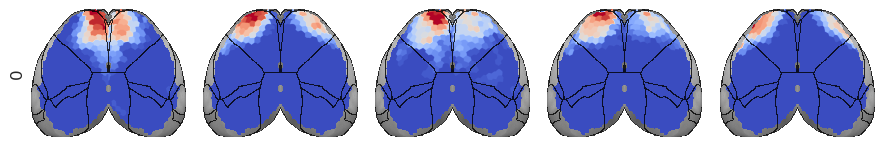

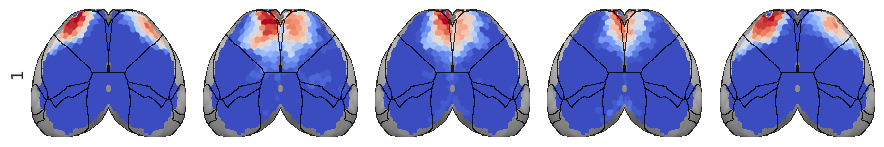

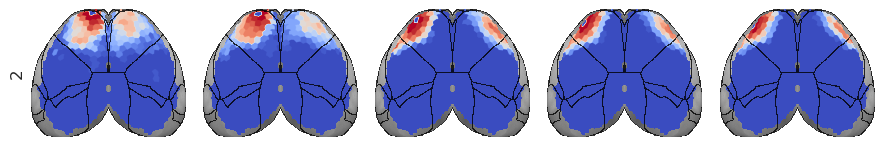

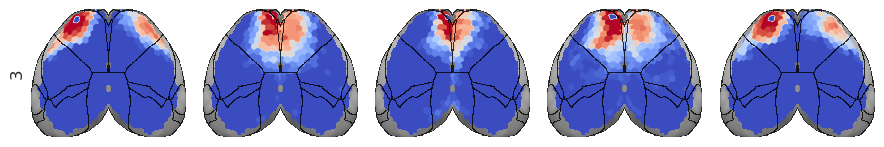

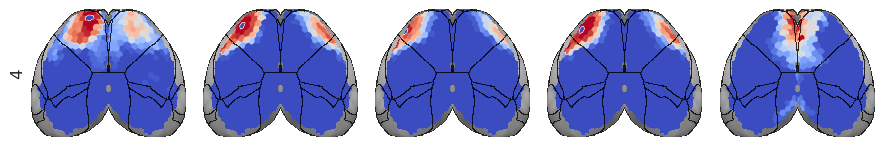

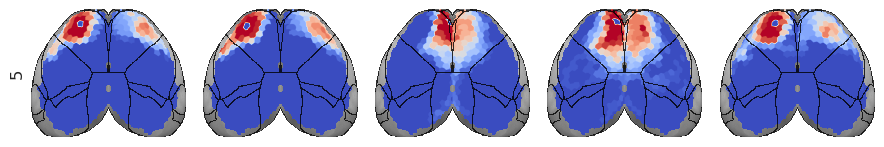

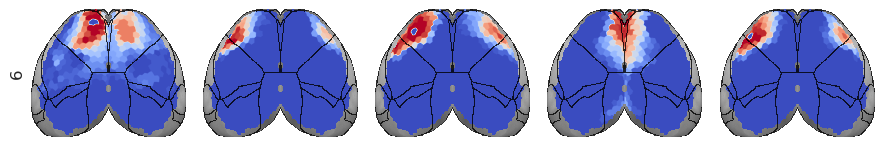

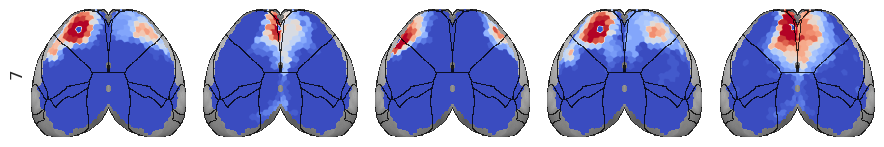

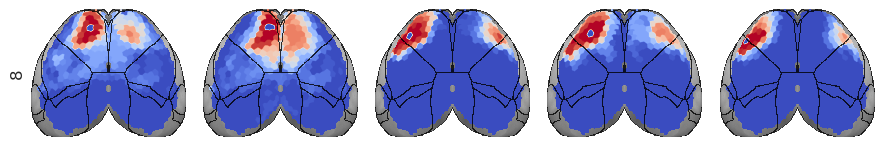

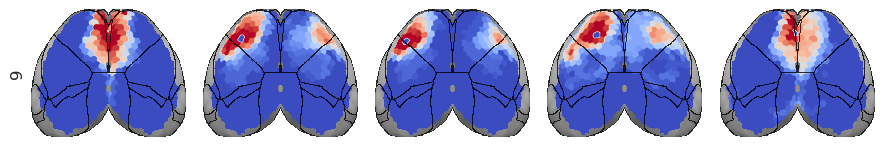

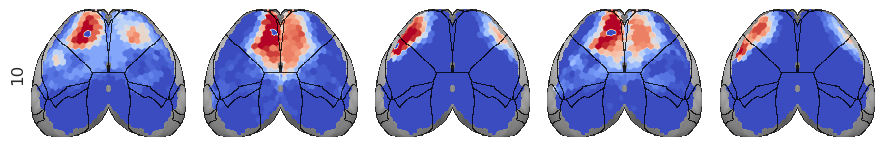

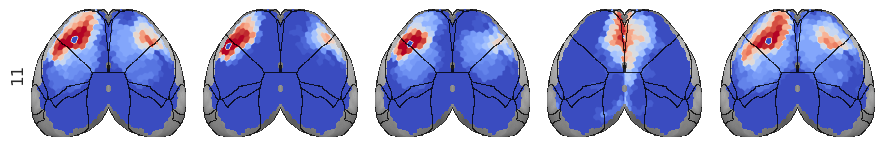

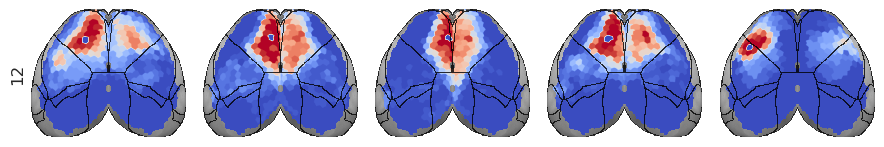

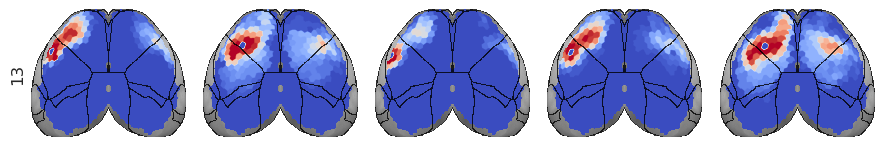

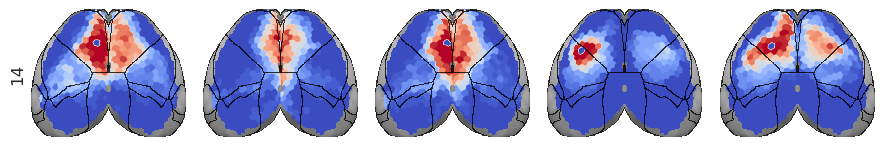

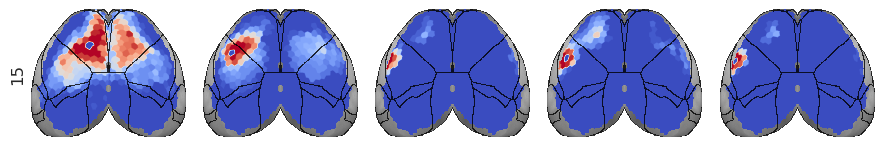

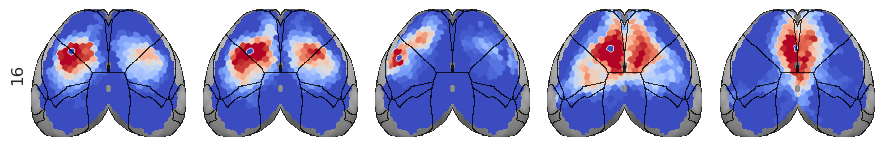

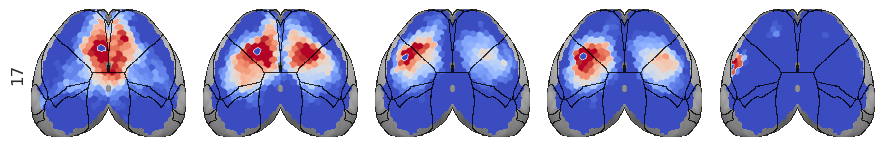

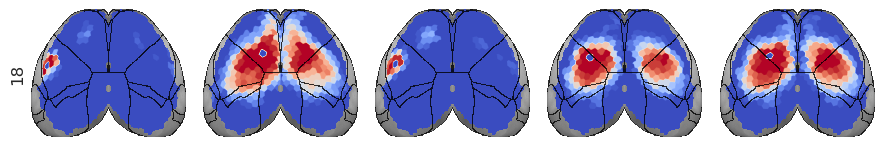

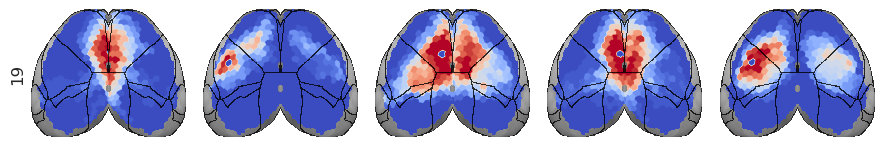

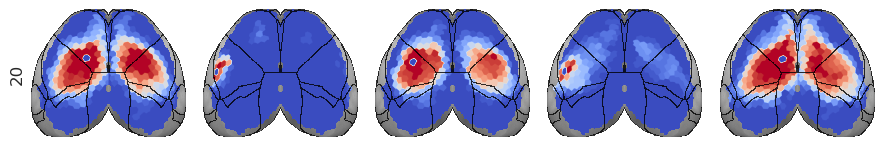

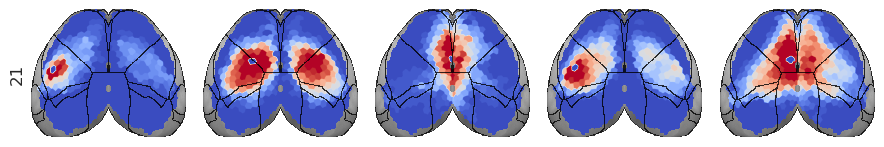

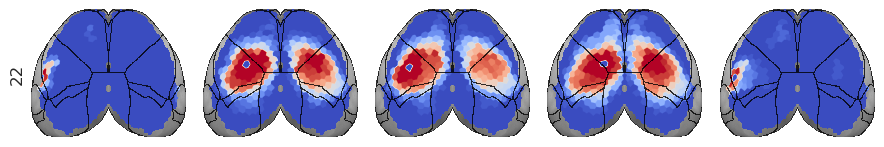

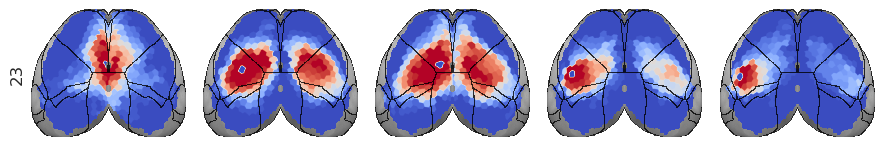

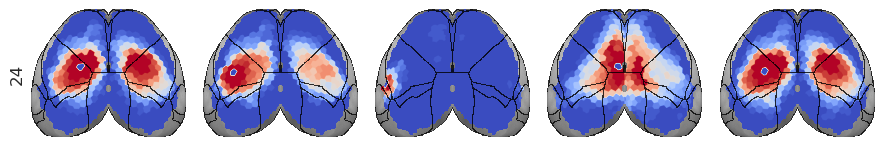

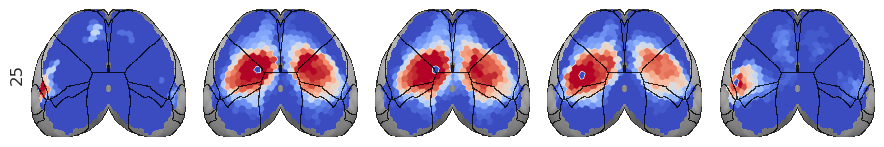

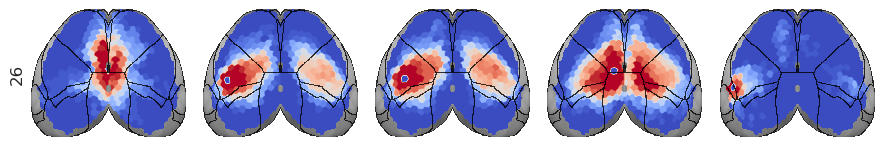

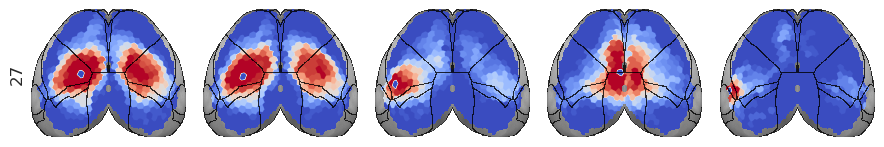

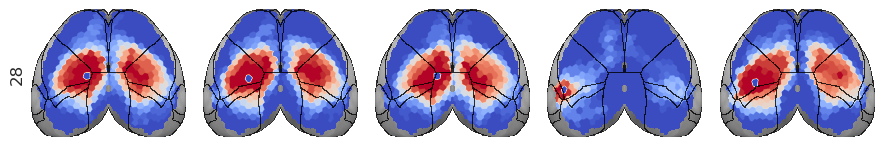

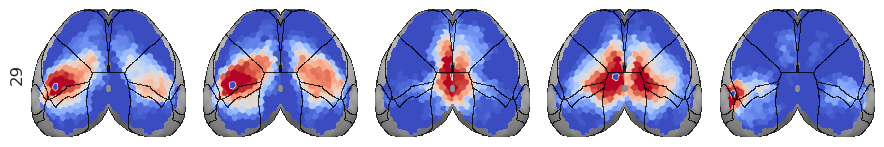

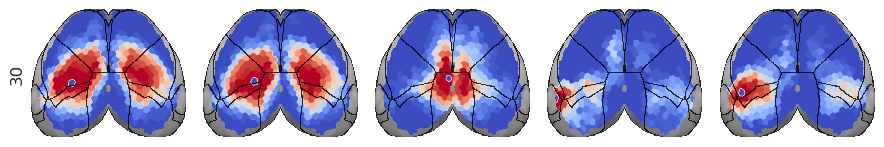

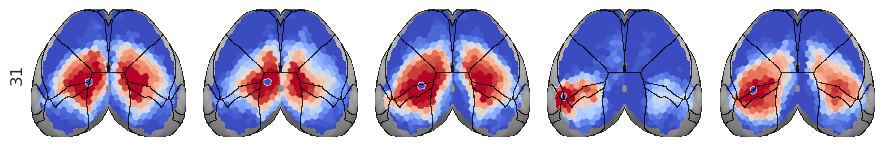

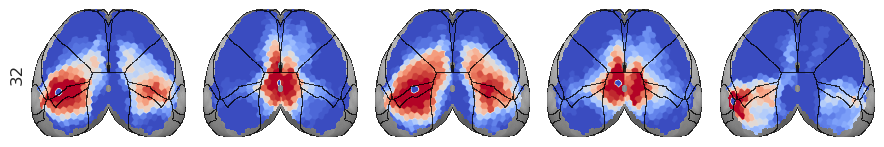

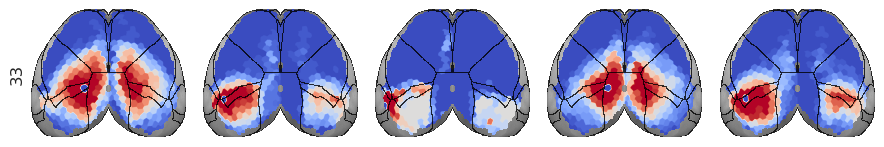

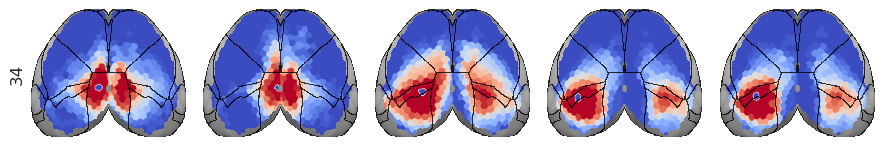

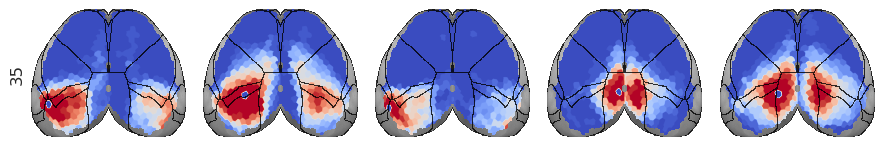

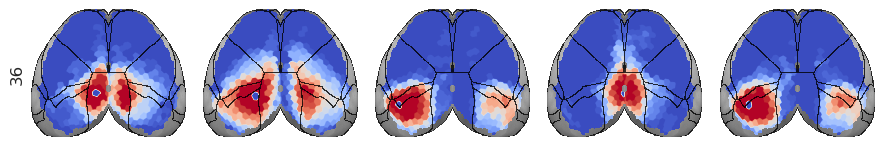

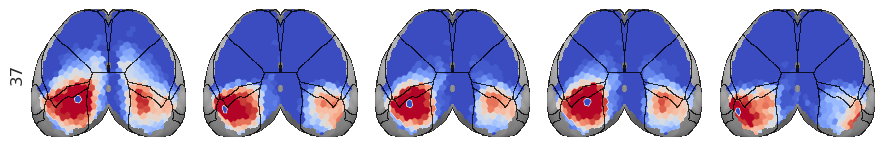

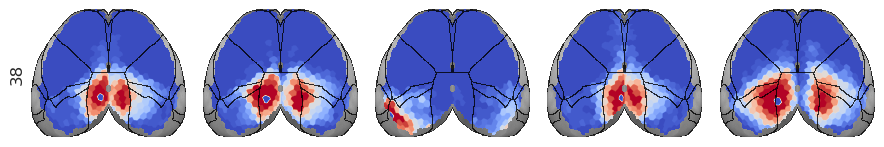

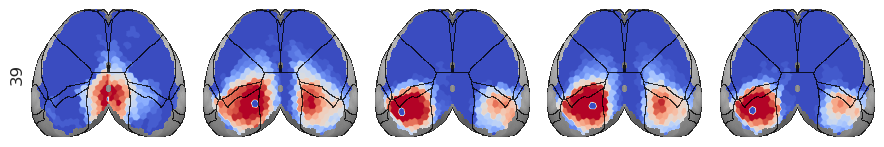

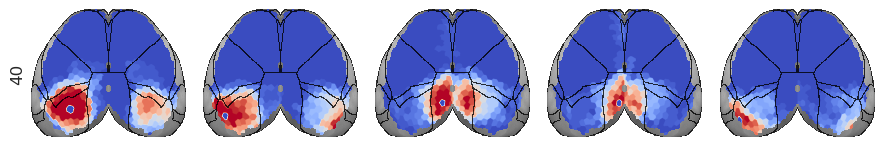

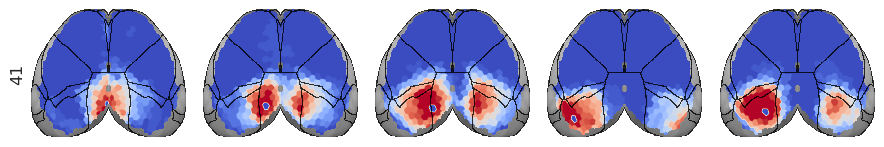

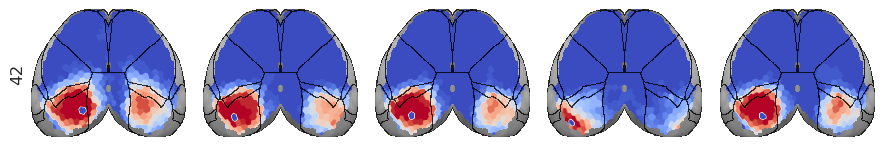

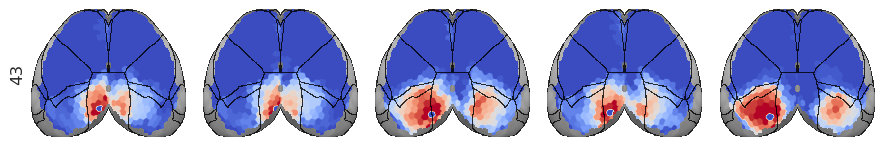

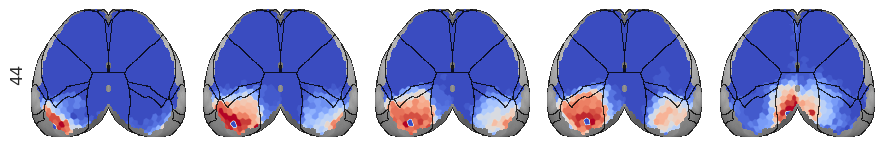

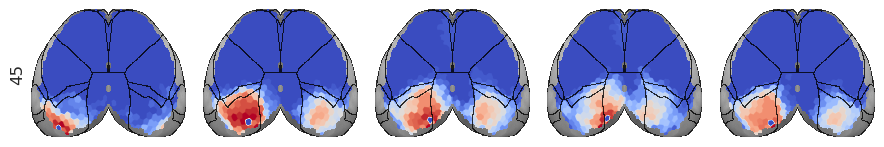

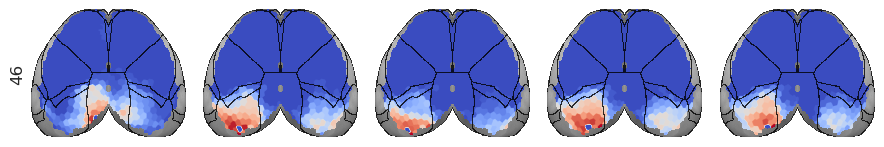

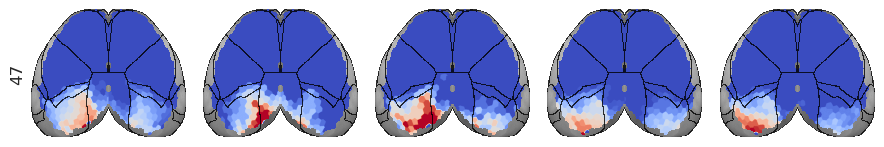

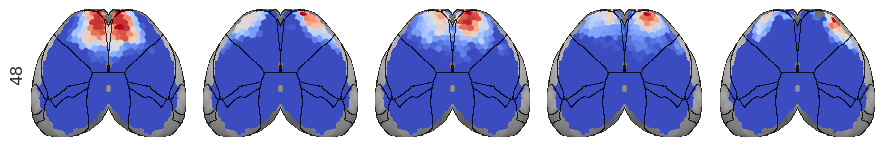

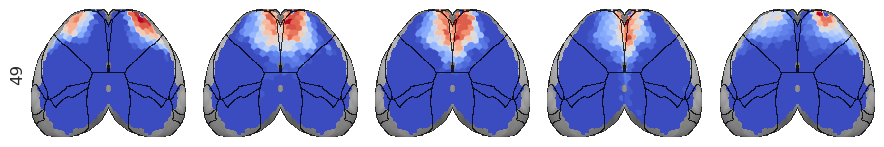

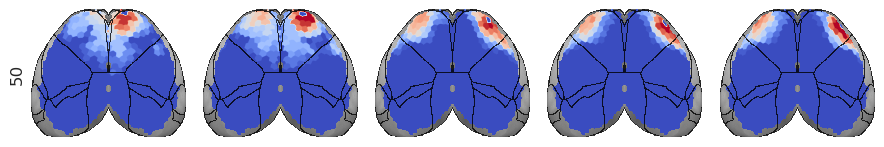

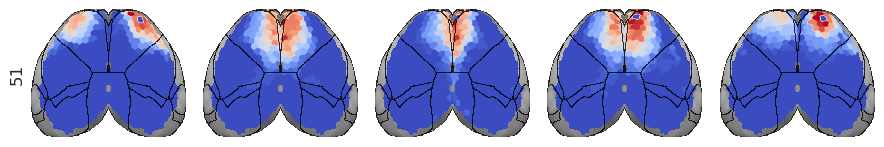

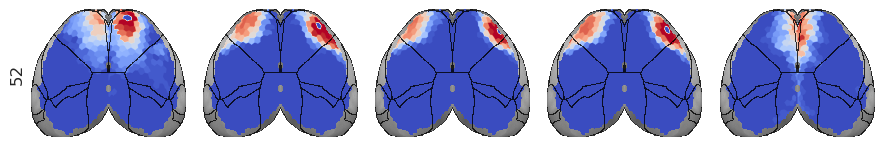

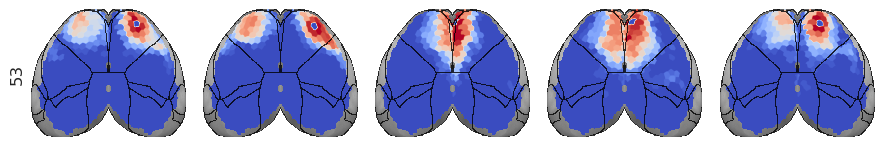

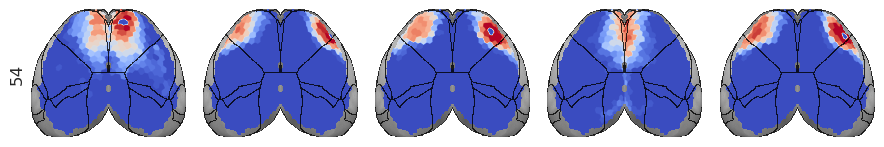

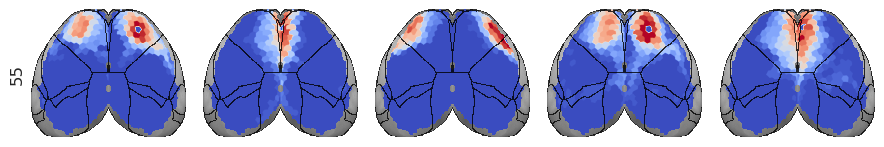

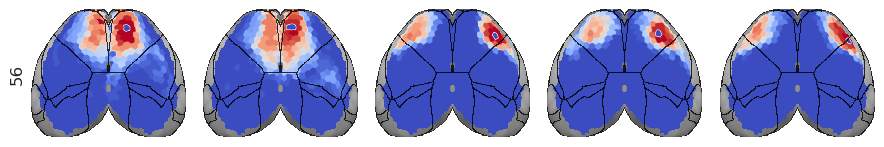

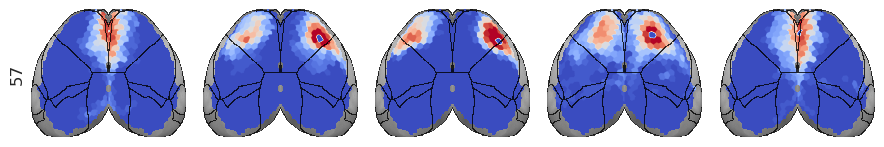

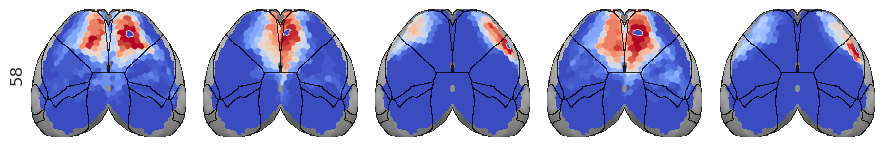

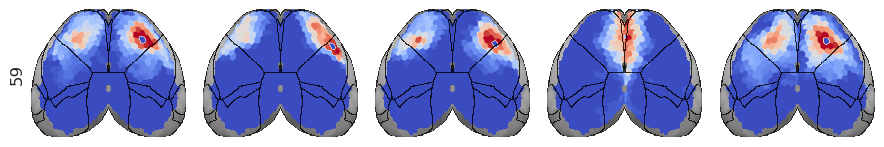

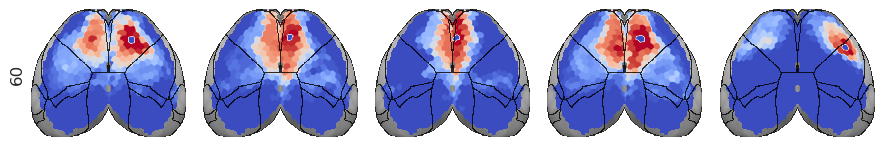

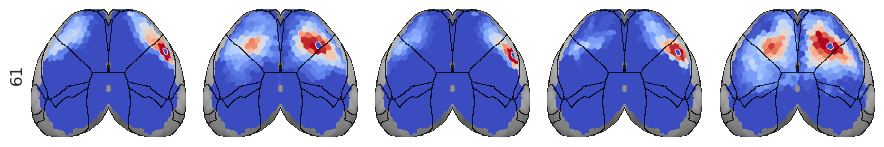

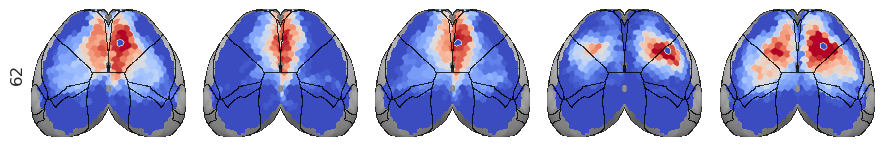

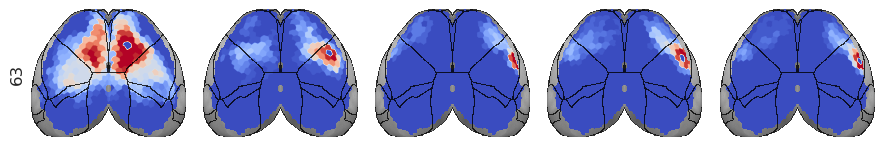

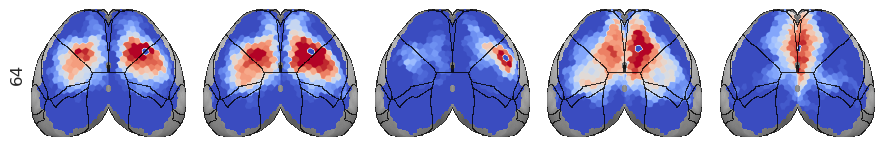

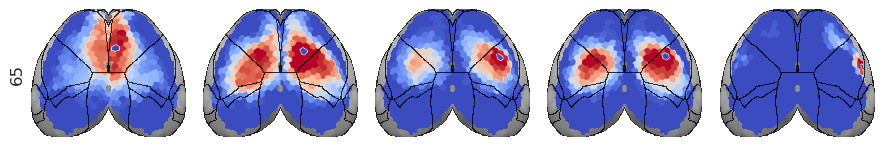

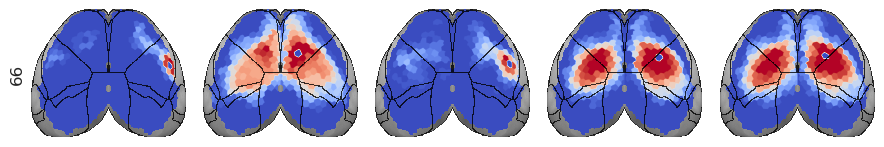

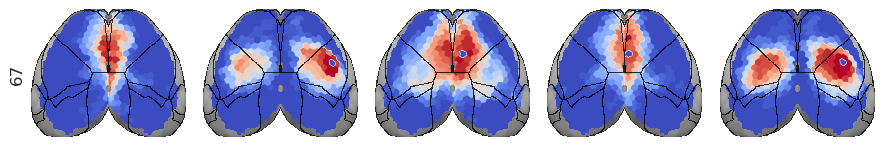

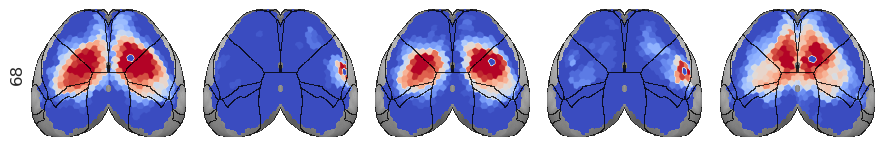

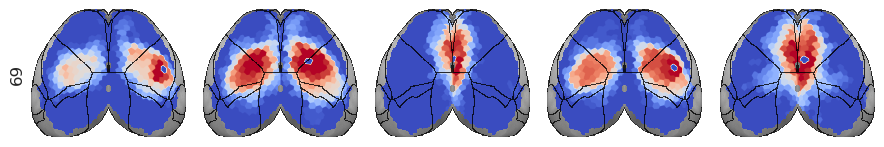

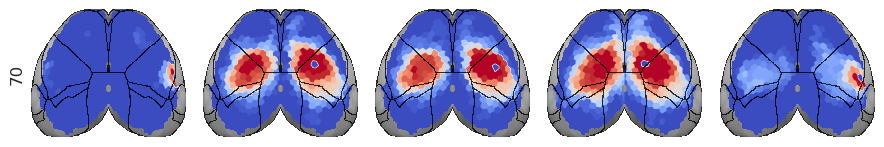

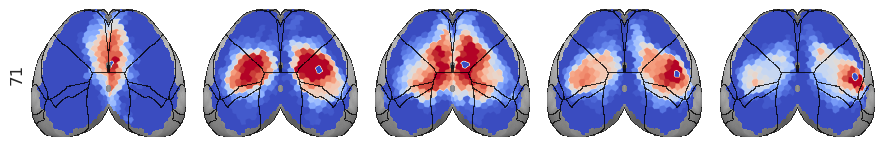

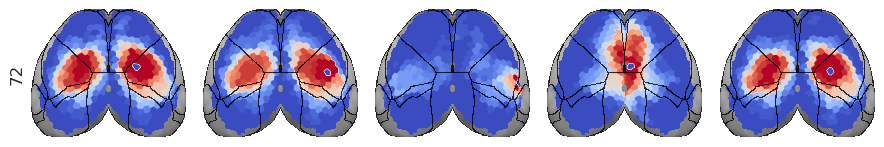

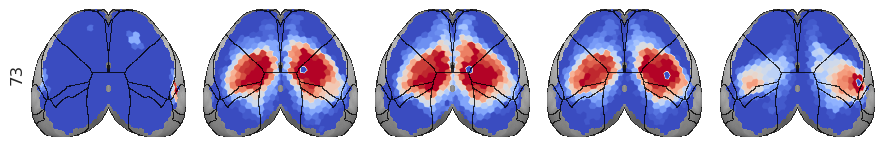

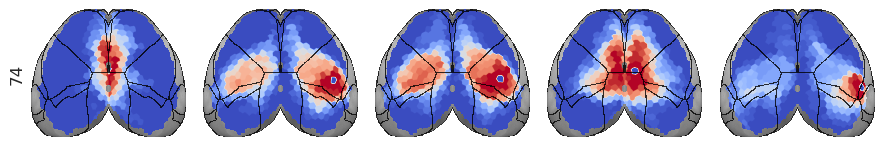

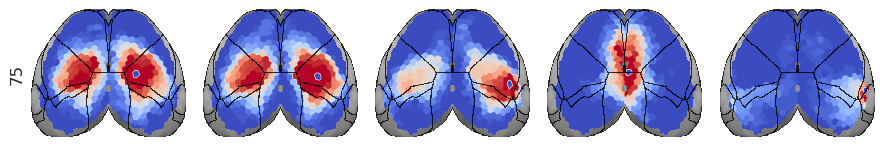

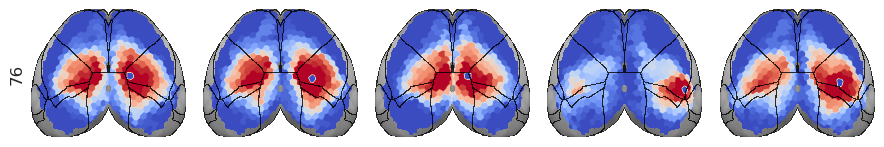

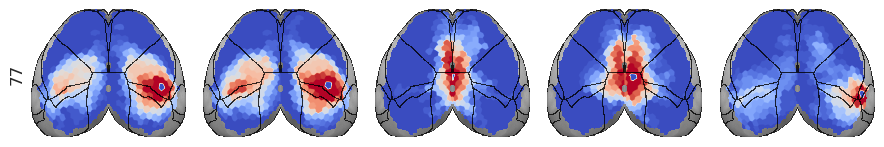

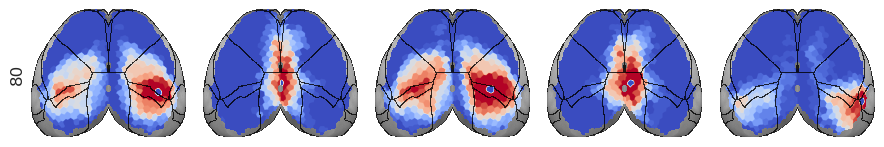

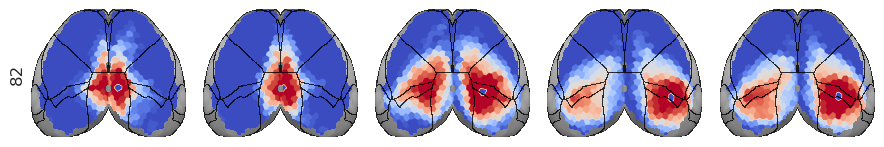

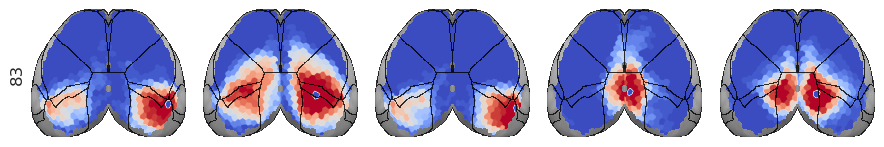

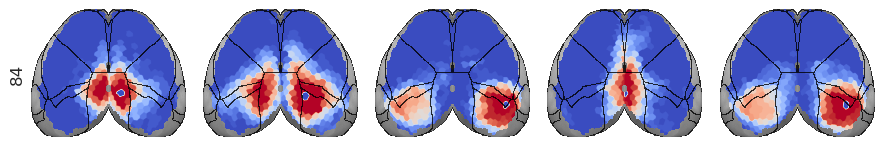

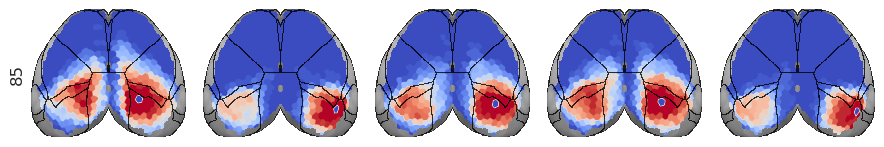

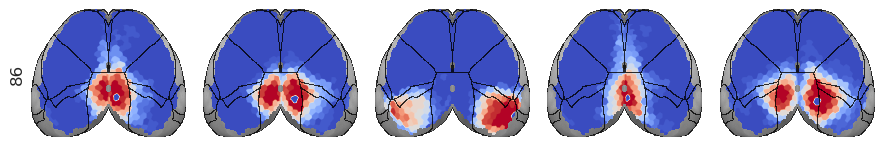

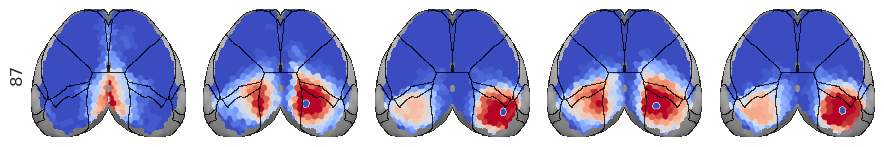

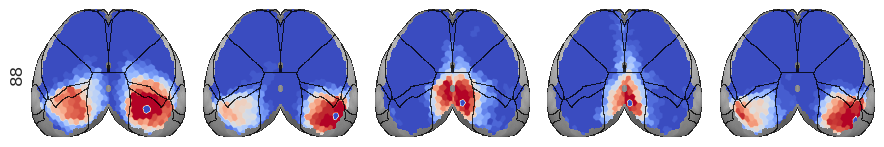

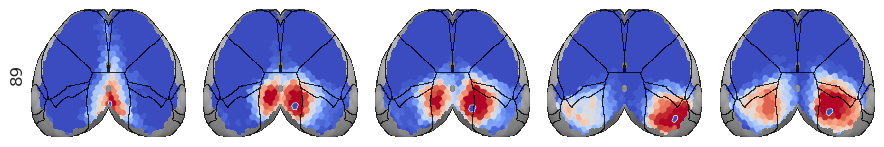

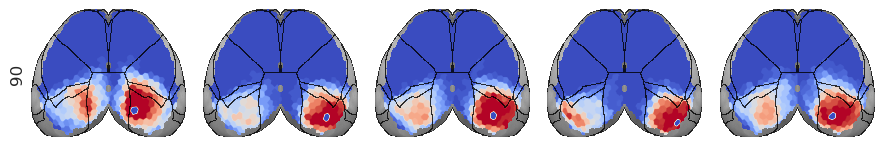

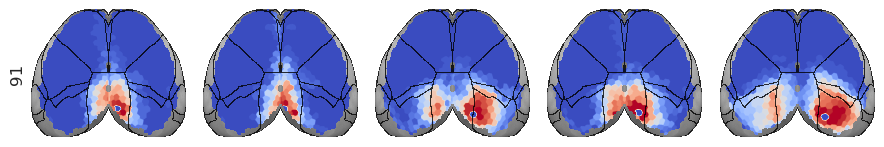

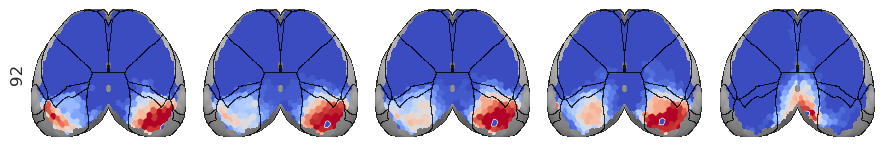

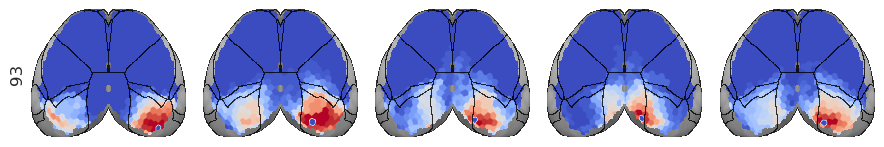

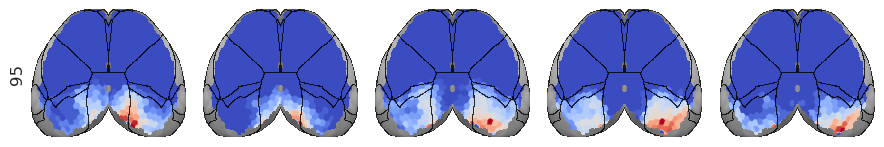

In [41]:
for i in range(int(np.ceil(480 / 5))):
    _ = bs.show(
        data={i: x[i*5:(i+1)*5]},
        figsize=(9, 1.8),
        vmin=0,
        vmax=None,
        add_disjoint=False,
        contour_cmap='Greys_r',
        cmap='coolwarm',
        cbar=False,
    )